In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = catalog.load('master_table')

Clients differ between each other on different levels.    

At this point I want to focus only on the information that says if it is a New customer or if it is Existing Customer.

I don't have a historical transaction for a New customers and in this case they should have a separate model build.
Below I want to check if having at least 1 transaction is enough.     

# Create segments

In [3]:
df_new_customer = df.loc[df['rank']==1].reset_index(drop=True)
df_existing_customer = df.loc[df['rank']>1].reset_index(drop=True)

In [4]:
df_new_customer.default.mean()

0.09066567694387742

In [5]:
df_existing_customer.default.mean()

0.09097233725360278

In [6]:
df_new_customer.late.mean()

0.2958829299329286

In [7]:
df_existing_customer.late.mean()

0.2942764066037215

Further in this analysis I will focus on Existing Customer

# Data split

In [8]:
params_ds = catalog.load('params:data_set')

df_train - dataset for model training,    
df_test  - dataset for model performance assessing (out of sample)    
df_valid - dataset for hp tuning (out of sample),   

In [9]:
params_ds

{'train': 0.7, 'test': 0.2, 'valid': 0.1}

In [10]:
size=df_existing_customer.shape[0]
train_size = int(size * params_ds['train'])
test_size = int(size * params_ds['test'])

df_existing_customer=df_existing_customer.sample(frac=1, random_state=1)
df_train = df_existing_customer.iloc[:train_size].sort_index()
df_test = df_existing_customer.iloc[train_size:(train_size+test_size)].sort_index()
df_valid = df_existing_customer.iloc[(train_size+test_size):].sort_index()


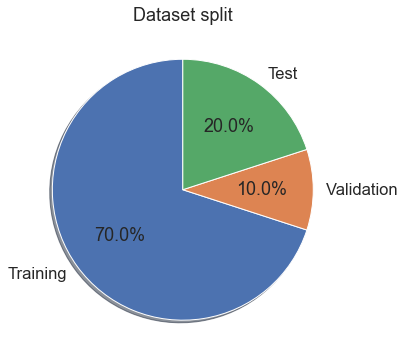

In [11]:

sns.set(font_scale=1.5)

# Pie chart
labels = ['Training', 'Validation ', 'Test']
sizes = [df_train.shape[0], df_valid.shape[0], df_test.shape[0]]
# only "explode" the 2nd slice (i.e. 'Hogs')
fig1, ax1 = plt.subplots(figsize=(10,6))
ax1.pie(sizes,  labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)

plt.title('Dataset split')

plt.show()

There are around 450K of observation in the segment of Existing Customer. 

* **df_train** - dataset for model training (EXISTING CUSTOMER),
* **df_test**  - dataset for model performance assessing (out of sample) (EXISTING CUSTOMER),
* **df_valid** - dataset for hp tuning (out of sample) (EXISTING CUSTOMER),


When there isn't so plenty of data, df_valid could be excluded from training data set at the stage of hyperparameter tuning, and put back before final training.

There could be at least one another dataset, but I don't use is because of nature of the data and the fact I don't have transaction date.

* **df_oot** - data set that will allow to check model performance on the latest available data (out of time) (EXISTING CUSTOMER),

# model lightgbm - no hp, just for feature importance

In [12]:
import numpy as np
from category_encoders import *

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_predict
from sklearn import metrics
from sklearn.metrics import roc_auc_score

import lightgbm as lgb
from lightgbm import LGBMClassifier

import matplotlib.pyplot as plt 

import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)


In [13]:
categorical_cols = ['sex', 'residentialAddress_clean',
                    'geo_risk_rank','shopID','same_address']
numerical_cols = ['age', 'income', 'price'] + \
    df.filter(regex='(^hist_)|(_lst_)').columns.to_list()
target_column = ['default']



In [14]:
lgb_params = {"seed": 42,
              "objective": "binary", 
              "learning_rate": 0.1,
              "metric":"auc"
              }

In [15]:
transformer = make_pipeline(
    ColumnTransformer([
        ('num','passthrough', numerical_cols),
        ('cat', OrdinalEncoder(), categorical_cols),    
    ]),
)

In [16]:
d_train = lgb.Dataset(
    transformer.fit_transform(df_train, df_train['default']), 
    label=df_train['default'], 
    feature_name=transformer.named_steps['columntransformer'].get_feature_names(),
    params={'verbose': -1})

d_valid = lgb.Dataset(
    transformer.transform(df_valid), 
    label=df_valid['default'], 
    feature_name=transformer.named_steps['columntransformer'].get_feature_names(),
    params={'verbose': -1})

d_test = lgb.Dataset(
    transformer.transform(df_test), 
    label=df_test['default'], 
    feature_name=transformer.named_steps['columntransformer'].get_feature_names(),
    params={'verbose': -1})

In [17]:
classifier = make_pipeline(
    ColumnTransformer([
        ('num','passthrough', numerical_cols),
        ('cat', OrdinalEncoder(), categorical_cols),       
    ]),
    LGBMClassifier(n_estimators=500, random_state=1, metric= "auc", importance_type='gain')
)

In [18]:
%%time
results=[]

for i in range(1,11): 
    _tmp_target = df.loc[df['rank']==i].reset_index(drop=True)[target_column].values.reshape(-1,)
    oof_pred = cross_val_predict(classifier, 
                                 df.loc[df['rank']==i].reset_index(drop=True), 
                                 _tmp_target, 
                                 cv=5,
                                 method="predict_proba")
    _tmp_roc_score = roc_auc_score(_tmp_target, oof_pred[:,1])
    results += [(i, _tmp_roc_score)]
    print("#{}, Cross validation AUC {:.4f}".format(i, _tmp_roc_score))

    
_tmp_target = df[target_column].values.reshape(-1,)
oof_pred = cross_val_predict(classifier, 
                             df, 
                             _tmp_target, 
                             cv=5,
                             method="predict_proba")
_tmp_roc_score = roc_auc_score(_tmp_target, oof_pred[:,1])
results += [(i, _tmp_roc_score)]
print("#ALL, Cross validation AUC {:.4f}".format(_tmp_roc_score))

#1, Cross validation AUC 0.6159
#2, Cross validation AUC 0.6189
#3, Cross validation AUC 0.6307
#4, Cross validation AUC 0.6387
#5, Cross validation AUC 0.6421
#6, Cross validation AUC 0.6311
#7, Cross validation AUC 0.6276
#8, Cross validation AUC 0.6191
#9, Cross validation AUC 0.5909
#10, Cross validation AUC 0.5702
#ALL, Cross validation AUC 0.6597
CPU times: user 13min 13s, sys: 1min 36s, total: 14min 49s
Wall time: 11min 54s


In [19]:
model = lgb.train(
    lgb_params,
    d_train,
    valid_sets=[d_train, d_valid],
    valid_names=['train', 'valid'],
)

[LightGBM] [Info] Number of positive: 28816, number of negative: 288126
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.152218 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7655
[LightGBM] [Info] Number of data points in the train set: 316942, number of used features: 75
[1]	train's auc: 0.664217	valid's auc: 0.672178
[2]	train's auc: 0.667457	valid's auc: 0.671004
[3]	train's auc: 0.667925	valid's auc: 0.671931
[4]	train's auc: 0.6688	valid's auc: 0.671506
[5]	train's auc: 0.669049	valid's auc: 0.672512
[6]	train's auc: 0.669668	valid's auc: 0.671635
[7]	train's auc: 0.670048	valid's auc: 0.671611
[8]	train's auc: 0.670568	valid's auc: 0.671816
[9]	train's auc: 0.671118	valid's auc: 0.671536
[10]	train's auc: 0.671737	valid's auc: 0.671632
[11]	train's auc: 0.671894	valid's auc: 0.67148
[12]	train's auc: 0.671976	valid's auc: 0.67

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

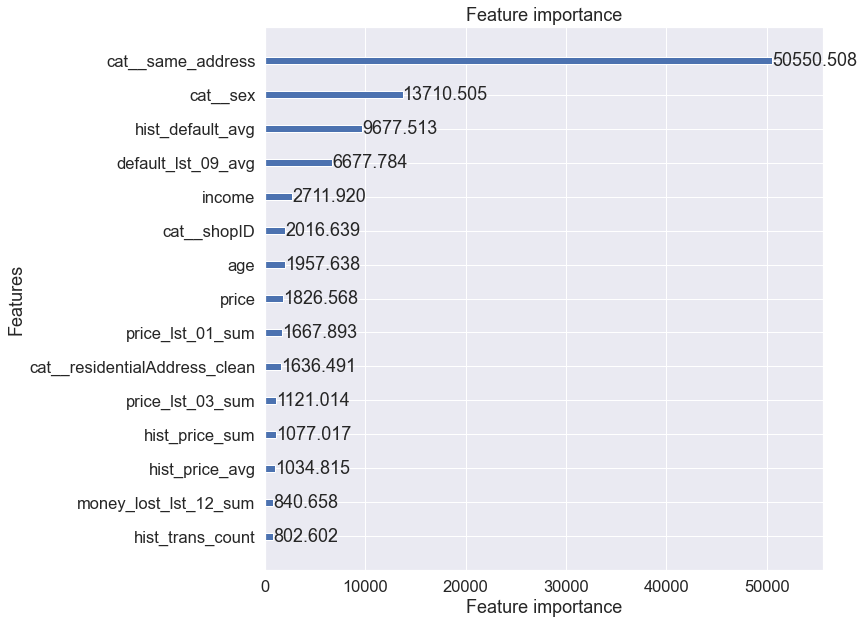

In [20]:
fig, ax2 = plt.subplots(figsize=(10,10))
lgb.plot_importance(model, max_num_features=15, ax=ax2, importance_type = 'gain')